<a href="https://www.kaggle.com/code/chiehjulin/tps-aug-2022?scriptVersionId=103696153" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Key Takeways for this competition
Below are based on my own experience. If you have new findings or different opinions feel free to leave comments. I'll be more than happy to learn.

> Attribute features are useless and can be dropped

> Use linear models instead of tree based boost models (even though the scores are still quite close)

> Group data by product code and impute missing values seems to be a good idea but didn't really improve the predictive power too much


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy

from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import make_pipeline

from sklearn.metrics import roc_auc_score, roc_curve

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

import warnings
import time
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)
warnings.filterwarnings('ignore')

RANDOM_STATE = 777
FOLDS = 5

## Importing Data

In [2]:
train = pd.read_csv('../input/tabular-playground-series-aug-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-aug-2022/test.csv')
submission = pd.read_csv('../input/tabular-playground-series-aug-2022/sample_submission.csv')

In [3]:
train['df'] = 'train'
test['df'] = 'test'

all = pd.concat([train, test]).reset_index()

train.drop('df', axis = 1, inplace = True)
test.drop('df', axis = 1, inplace = True)

<div class = "alert alert-info" role = "alert" style="font-size:14px; font-family:verdana;">

📌 <b><u>Quick Overview in Train Data</u></b><br>

* There are 26 columns: 1 row id, 1 target variable, 5 categorical (product code and attribute columns), and 19 continuous<br>
* Even though attribute_2 and attribute_3 have int64 as data type, I would consider them as categorical features. And for measurement_0, measurement_1, and measurement_2, I would consider them as continuous features. <b><u>I assume similar features should have same data type</u></b><br>
* There are total of 26,570 rows in train dataset<br>
* <b><u>"failure"</u></b> is the our target variable, which is a categorical variable with <b><u>0</u></b> and <b><u>1</u></b> as possible values
* There are 20,273 missing values in this dataset<br>
* The missing values are in numeric columns only (loading, measurement_3 - measurement_17)<br>
* This is a <b><u>classification</u></b> problem<br>
* We have slightly <b><u>imbalance class</u></b> as there are 78.7% "0" and 21.2% "1" in target column<br>
    
</div>

In [4]:
train.shape

(26570, 26)

In [5]:
train.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.100000,material_7,material_8,9,5,7,8,4,18.040000,12.518000,15.748000,19.292000,11.739000,20.155000,10.672000,15.859000,17.594000,15.193000,15.029000,NaN,13.034000,14.684000,764.100000,0
1,1,A,84.890000,material_7,material_8,9,5,14,3,3,18.213000,11.540000,17.717000,17.893000,12.748000,17.889000,12.448000,17.947000,17.915000,11.755000,14.732000,15.425000,14.395000,15.631000,682.057000,0
2,2,A,82.430000,material_7,material_8,9,5,12,1,5,18.057000,11.652000,16.738000,18.240000,12.718000,18.288000,12.715000,15.607000,NaN,13.798000,16.711000,18.631000,14.094000,17.946000,663.376000,0
3,3,A,101.070000,material_7,material_8,9,5,13,2,6,17.295000,11.188000,18.576000,18.339000,12.583000,19.060000,12.471000,16.346000,18.377000,10.020000,15.250000,15.562000,16.154000,17.172000,826.282000,0
4,4,A,188.060000,material_7,material_8,9,5,9,2,8,19.346000,12.950000,16.990000,15.746000,11.306000,18.093000,10.337000,17.082000,19.932000,12.428000,16.182000,12.760000,13.153000,16.412000,579.885000,0


In [6]:
print(f'\033[92mNumber of rows in the table: {train.shape[0]}')
print(f'\033[94mNumber of columns in the table: {train.shape[1]}')
print(f'\033[91mNumber of observations in the table: {train.count().sum()}')
print(f'\033[91mNumber of missing values in the table: {sum(train.isnull().sum())}')
print(f'\033[91mNumber of duplicated records: {train.duplicated().sum()}')
print()
print(f'\033[95mData types')
print(f'\033[90m{train.dtypes}')
print()
print(f'\033[95mData type counts')
print(f'\033[90m{train.dtypes.value_counts()}')
print()
print(f'\033[95mUnique value in each column')
print(f'\033[90m{train.nunique()}')

Number of rows in the table: 26570
Number of columns in the table: 26
Number of observations in the table: 670547
Number of missing values in the table: 20273
Number of duplicated records: 0

Data types
id                  int64
product_code       object
loading           float64
attribute_0        object
attribute_1        object
attribute_2         int64
attribute_3         int64
measurement_0       int64
measurement_1       int64
measurement_2       int64
measurement_3     float64
measurement_4     float64
measurement_5     float64
measurement_6     float64
measurement_7     float64
measurement_8     float64
measurement_9     float64
measurement_10    float64
measurement_11    float64
measurement_12    float64
measurement_13    float64
measurement_14    float64
measurement_15    float64
measurement_16    float64
measurement_17    float64
failure             int64
dtype: object

Data type counts
float64    16
int64       7
object      3
dtype: int64

Unique value in each column
id   

In [7]:
print(f'\033[95mmissing value in each column')
train.isnull().sum()

missing value in each column


id                   0
product_code         0
loading            250
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      381
measurement_4      538
measurement_5      676
measurement_6      796
measurement_7      937
measurement_8     1048
measurement_9     1227
measurement_10    1300
measurement_11    1468
measurement_12    1601
measurement_13    1774
measurement_14    1874
measurement_15    2009
measurement_16    2110
measurement_17    2284
failure              0
dtype: int64

In [8]:
train.describe()

,id,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
count,26570.000000,26320.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26189.000000,26032.000000,25894.000000,25774.000000,25633.000000,25522.000000,25343.000000,25270.000000,25102.000000,24969.000000,24796.000000,24696.000000,24561.000000,24460.000000,24286.000000,26570.000000
mean,13284.500000,127.826233,6.754046,7.240459,7.415883,8.232518,6.256568,17.791528,11.731988,17.127804,17.510759,11.716624,19.024714,11.430725,16.117711,19.172085,11.702464,15.652904,16.048444,14.995554,16.460727,701.269059,0.212608
std,7670.242662,39.030020,1.471852,1.456493,4.116690,4.199401,3.309109,1.001200,0.996085,0.996414,0.995980,1.000836,1.008591,0.999137,1.405978,1.520785,1.488838,1.155247,1.491923,1.549226,1.708935,123.304161,0.409160
min,0.000000,33.160000,5.000000,5.000000,0.000000,0.000000,0.000000,13.968000,8.008000,12.073000,12.715000,7.968000,15.217000,7.537000,9.323000,12.461000,5.167000,10.890000,9.140000,9.104000,9.701000,196.787000,0.000000
25%,6642.250000,99.987500,6.000000,6.000000,4.000000,5.000000,4.000000,17.117000,11.051000,16.443000,16.839000,11.045000,18.340250,10.757000,15.209000,18.170000,10.703000,14.890000,15.057000,13.957000,15.268000,618.961500,0.000000
50%,13284.500000,122.390000,6.000000,8.000000,7.000000,8.000000,6.000000,17.787000,11.733000,17.132000,17.516000,11.712000,19.021000,11.430000,16.127000,19.211500,11.717000,15.628500,16.040000,14.969000,16.436000,701.024500,0.000000
75%,19926.750000,149.152500,8.000000,8.000000,10.000000,11.000000,8.000000,18.469000,12.410000,17.805000,18.178000,12.391000,19.708000,12.102000,17.025000,20.207000,12.709000,16.374000,17.082000,16.018000,17.628000,784.090250,0.000000
max,26569.000000,385.860000,9.000000,9.000000,29.000000,29.000000,24.000000,21.499000,16.484000,21.425000,21.543000,15.419000,23.807000,15.412000,22.479000,25.640000,17.663000,22.713000,22.303000,21.626000,24.094000,1312.794000,1.000000


In [9]:
(train['failure'].value_counts()/train['failure'].count())*100

0   78.739180
1   21.260820
Name: failure, dtype: float64

<div class = "alert alert-info" role = "alert" style="font-size:14px; font-family:verdana;">

📌 <b><u>Quick Overview in Test Data</u></b><br>

* There are 25 columns: 1 row id, 5 categorical (product code and attribute columns), and 19 continuous<br>
* There are total of 20,775 rows in test dataset, which is around <b><u>78.19%</u></b> of Train Data<br>
* There are missing / null values in this dataset
    
</div>

In [10]:
test.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,26570,F,119.570000,material_5,material_6,6,4,6,9,6,19.305000,10.178000,17.534000,18.168000,11.598000,18.654000,10.802000,15.909000,18.070000,13.772000,13.659000,16.825000,13.742000,17.710000,634.612000
1,26571,F,113.510000,material_5,material_6,6,4,11,8,0,17.883000,11.927000,17.228000,16.033000,11.179000,19.368000,12.032000,13.998000,NaN,12.473000,17.468000,16.708000,14.776000,14.102000,537.037000
2,26572,F,112.160000,material_5,material_6,6,4,8,12,4,18.475000,10.481000,16.619000,18.189000,12.126000,17.774000,11.743000,17.046000,18.086000,10.907000,13.363000,15.737000,17.065000,16.021000,658.995000
3,26573,F,112.720000,material_5,material_6,6,4,8,11,10,16.518000,10.888000,15.293000,18.592000,11.304000,18.948000,11.790000,18.165000,16.163000,10.933000,15.501000,15.667000,12.620000,16.111000,594.301000
4,26574,F,208.000000,material_5,material_6,6,4,14,16,8,17.808000,12.693000,17.678000,15.814000,13.431000,19.141000,12.370000,14.578000,17.849000,11.941000,16.070000,16.183000,13.324000,17.150000,801.044000


In [11]:
print(f'\033[92mNumber of rows in the table: {test.shape[0]}')
print(f'\033[94mNumber of columns in the table: {test.shape[1]}')
print(f'\033[91mNumber of observations in the table: {test.count().sum()}')
print(f'\033[91mNumber of missing values in the table: {sum(test.isnull().sum())}')
print(f'\033[91mNumber of duplicated records: {test.duplicated().sum()}')
print()
print(f'\033[95mData types')
print(f'\033[90m{test.dtypes}')
print()
print(f'\033[95mData type counts')
print(f'\033[90m{test.dtypes.value_counts()}')
print()
print(f'\033[95mUnique value in each column')
print(f'\033[90m{test.nunique()}')

Number of rows in the table: 20775
Number of columns in the table: 25
Number of observations in the table: 503666
Number of missing values in the table: 15709
Number of duplicated records: 0

Data types
id                  int64
product_code       object
loading           float64
attribute_0        object
attribute_1        object
attribute_2         int64
attribute_3         int64
measurement_0       int64
measurement_1       int64
measurement_2       int64
measurement_3     float64
measurement_4     float64
measurement_5     float64
measurement_6     float64
measurement_7     float64
measurement_8     float64
measurement_9     float64
measurement_10    float64
measurement_11    float64
measurement_12    float64
measurement_13    float64
measurement_14    float64
measurement_15    float64
measurement_16    float64
measurement_17    float64
dtype: object

Data type counts
float64    16
int64       6
object      3
dtype: int64

Unique value in each column
id                20775
product

In [12]:
print(f'\033[95mmissing value in each column')
test.isnull().sum()

missing value in each column


id                   0
product_code         0
loading            223
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      329
measurement_4      409
measurement_5      508
measurement_6      624
measurement_7      720
measurement_8      846
measurement_9      904
measurement_10    1067
measurement_11    1136
measurement_12    1240
measurement_13    1303
measurement_14    1440
measurement_15    1542
measurement_16    1678
measurement_17    1740
dtype: int64

In [13]:
print("Test set rows / Train set rows = " + str(round(test.count()[0] / train.count()[0] * 100, 2)))

Test set rows / Train set rows = 78.19


# Exploratory Data Analysis

<div class = "alert alert-info" role = "alert" style="font-size:14px; font-family:verdana;">

🔍 <b><u>Findings Summary</u></b><br>

* Distriution of categorical variables between train and test set<br>
    -- Values for categorical variables are <b>very different</b> between Train and Test set, especially the <b><u>product_code</u></b> variable <br>
* Relationship between categorical variables and target variable<br>
    -- I don't see a very strong relationship between categorical variables and target variable<br>
* Based on the two observations above, categorical variables might not be good indicators to predict target<br>    
* For numeric variables, <b>loading</b> seems to have higher correlation with target variable - failure<br>
    
</div>

#### Let's create some feature groups for future reference

In [14]:
categorical_cols = [col for col in train.columns if train[col].dtype == 'object' or col.startswith('attribute')]
continuous_cols = [col for col in train.columns if col.startswith('measurement') or col == 'loading']
attribute_cols = [col for col in train.columns if col.startswith('attribute')]
measurement_cols = [col for col in train.columns if col.startswith('measurement')]

#### Distribution of Categorical Variables

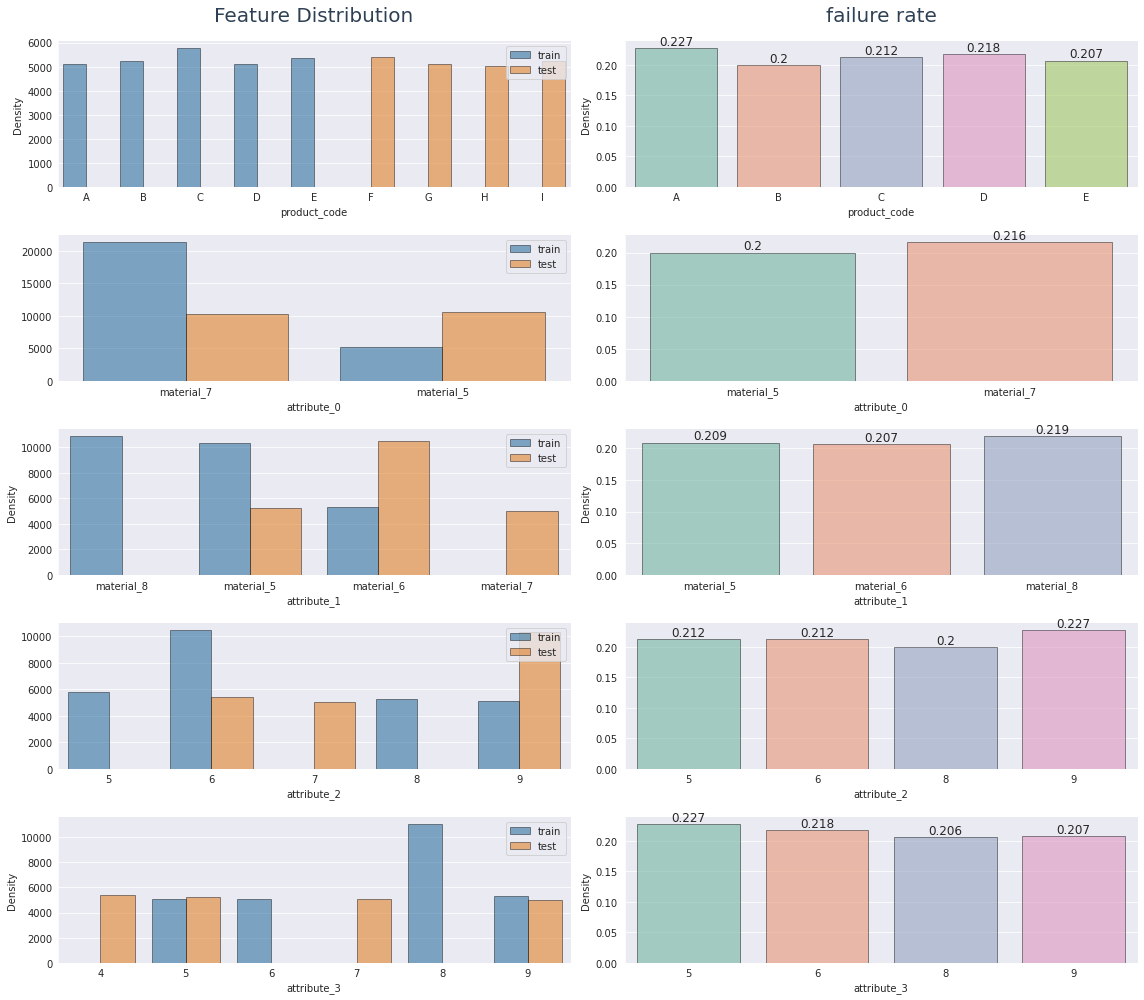

In [15]:
sns.set_style('darkgrid')
fig = plt.figure(figsize = (16, 14))
rows = 5
cols = 2

#### Plot Distribution for train and test

for idx, col in enumerate(categorical_cols):
  ax = fig.add_subplot(rows, cols, idx*2 + 1)
  sns.countplot(x = col, data = all, fill = True, alpha = 0.6, linewidth = 0.7, edgecolor = '#000', hue = 'df')

  ax.xaxis.set_tick_params(labelsize=10, size=0, pad=5)
  ax.yaxis.set_tick_params(labelsize=10, size=0, pad=5)

  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  if idx % cols == 0:
    ax.set_ylabel('Density')
  else:
    ax.set_ylabel('')

  ax.set_xlabel(col)
  ax.legend(loc = 'upper right')
    
  if col == 'product_code':
    ax.set_title('Feature Distribution', fontsize = 20, color = '#2E4053', pad = 20)

#### Plot failure rate (target variable) for categorical variable

  ax1 = fig.add_subplot(rows, cols, idx*2 + 2)
  temp = train.failure.groupby(train[col]).mean().reset_index().round(3)
  sns.barplot(x = col, y = 'failure', data = temp, fill = True, alpha = 0.6, linewidth = 0.7, edgecolor = '#000', palette = 'Set2')

  ax1.xaxis.set_tick_params(labelsize=10, size=0, pad=5)
  ax.yaxis.set_tick_params(labelsize=10, size=0, pad=5)

  ax1.spines['right'].set_visible(False)
  ax1.spines['top'].set_visible(False)
  ax1.bar_label(ax1.containers[0], fontsize = 12)

  if idx % cols == 0:
    ax1.set_ylabel('Density')
  else:
    ax1.set_ylabel('')

  if col == 'product_code':
    ax1.set_title('failure rate', fontsize = 20, color = '#2E4053', pad = 20)

fig.tight_layout()
fig.show()

#### Distribution of Continuous Variables
> The loading feature seems to have `right skewed distribution`, we can apply log transformation to make the distribution normal

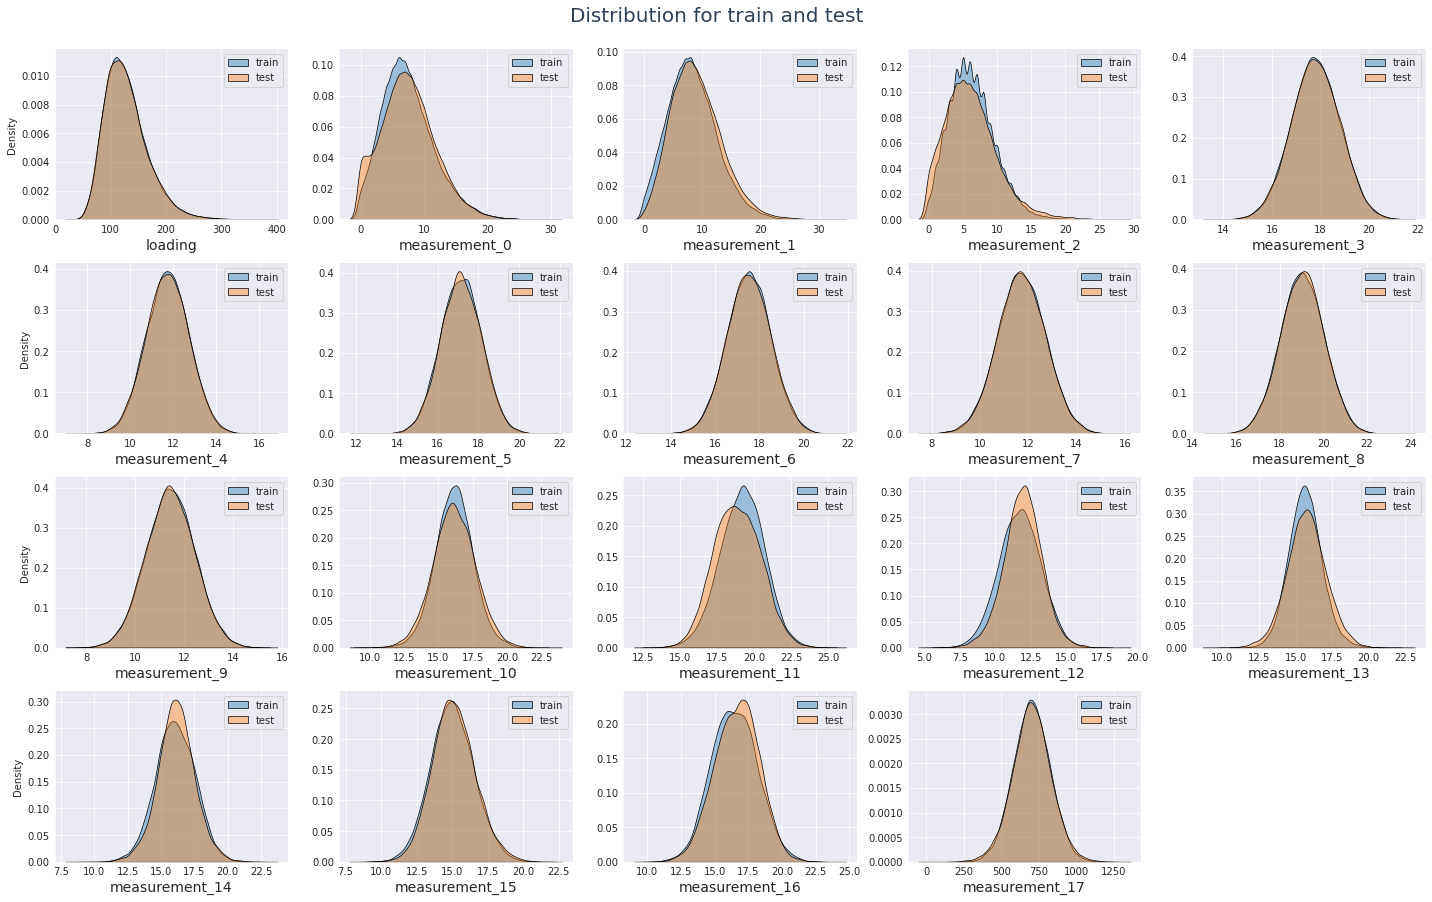

In [16]:
fig = plt.figure(figsize = (20, 15))
rows = 5
cols = 5

for idx, cont_col in enumerate(continuous_cols):
  ax = fig.add_subplot(rows, cols, idx + 1)
  sns.kdeplot(x = cont_col, data = train, fill = True, alpha = 0.4, linewidth = 0.7, edgecolor = '#000', label = 'train')
  sns.kdeplot(x = cont_col, data = test, fill = True, alpha = 0.4, linewidth = 0.7, edgecolor = '#000', label = 'test') 
    
  ax.xaxis.set_tick_params(labelsize=10, size=0, pad=5)
  ax.yaxis.set_tick_params(labelsize=10, size=0, pad=5)

  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  if idx % cols == 0:
    ax.set_ylabel('Density')
  else:
    ax.set_ylabel('')

  ax.set_xlabel(cont_col, fontsize = 14)
  ax.legend()

fig.suptitle('Distribution for train and test', fontsize = 20, color = '#2E4053', y = 1)
fig.tight_layout()
fig.show()

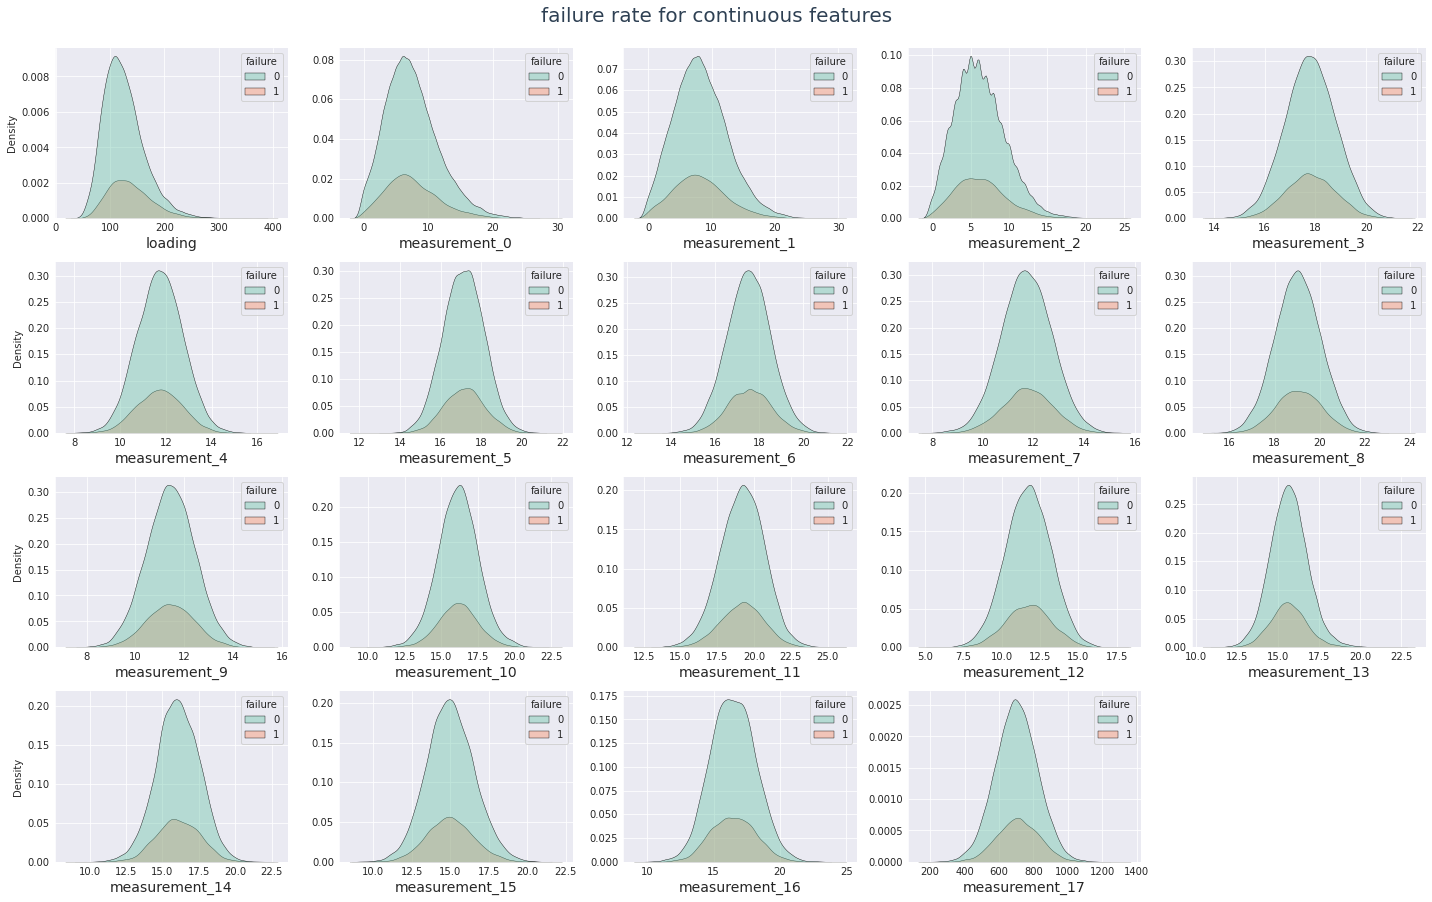

In [17]:
fig = plt.figure(figsize = (20, 15))
rows = 5
cols = 5

for idx, cont_col in enumerate(continuous_cols):
  ax = fig.add_subplot(rows, cols, idx + 1)
  sns.kdeplot(x = cont_col, data = train, fill = True, alpha = 0.4, linewidth = 0.4, edgecolor = '#000', hue = 'failure', palette = 'Set2', legend = 'brief')
    
  ax.xaxis.set_tick_params(labelsize=10, size=0, pad=5)
  ax.yaxis.set_tick_params(labelsize=10, size=0, pad=5)

  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  if idx % cols == 0:
    ax.set_ylabel('Density')
  else:
    ax.set_ylabel('')

  ax.set_xlabel(cont_col, fontsize = 14)

fig.suptitle('failure rate for continuous features', fontsize = 20, color = '#2E4053', y = 1)
fig.tight_layout()
fig.show()

Text(0.5, 1.0, 'Log transformed loading')

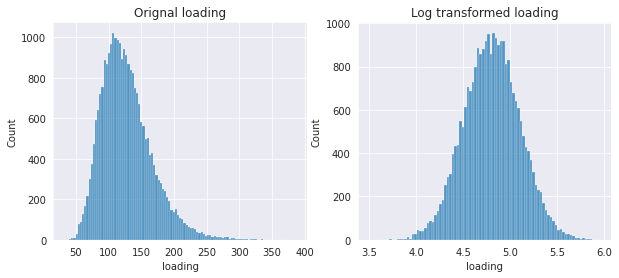

In [18]:
sns.set_style('darkgrid')
fig = plt.figure(figsize = (10, 4))
ax1 = fig.add_subplot(1,2,1)
sns.histplot(train['loading'])
ax1.set_title("Orignal loading")

ax2 = fig.add_subplot(1,2,2)
sns.histplot(np.log(train["loading"]))
ax2.set_title("Log transformed loading")

#### Check correlation
> There is no multicollinearity problem

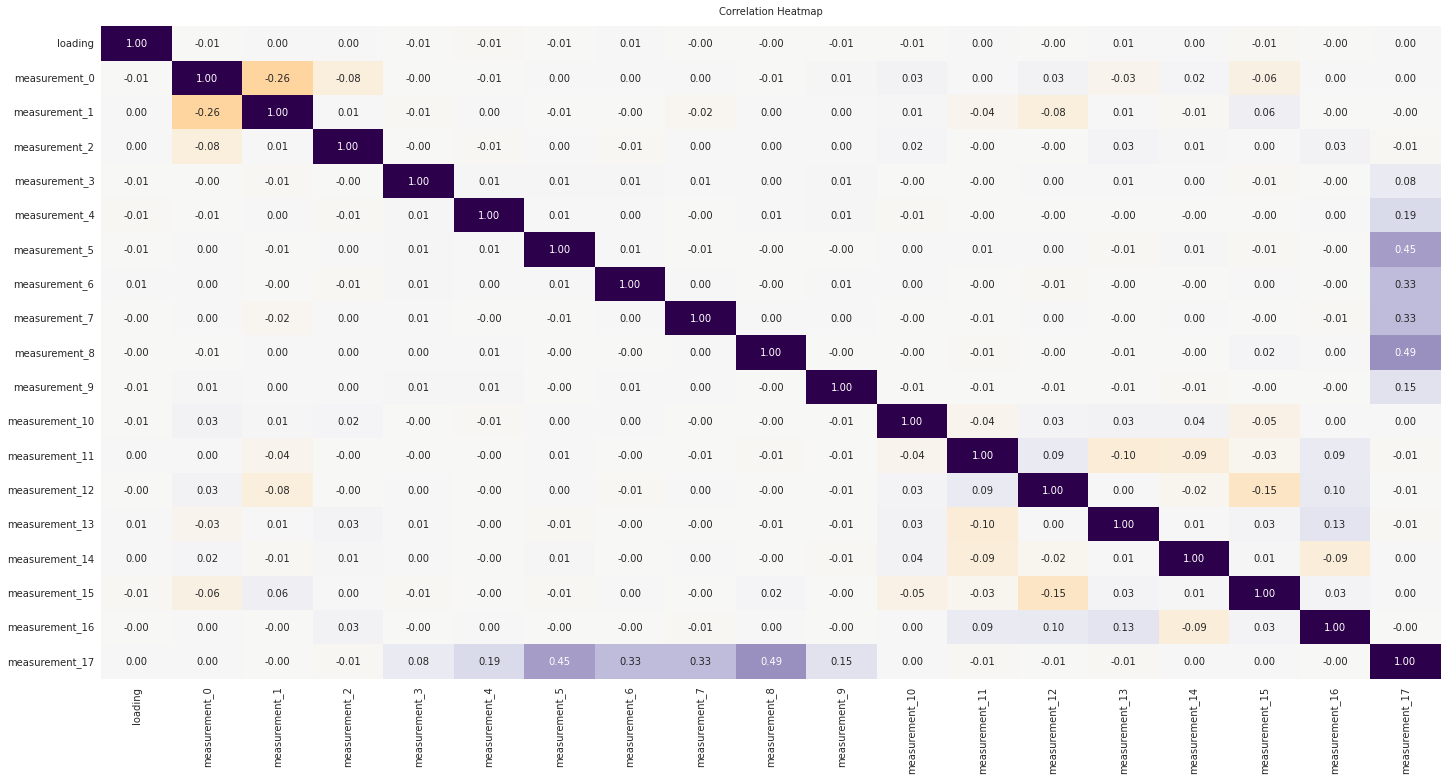

In [19]:
features = [col for col in train.columns if col in ('target', 'loading') or col.startswith('measurement')]

fig = plt.figure(figsize=(24, 12))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.

heatmap = sns.heatmap(train[features].corr(), vmin=-1, vmax=1, annot=True, cmap="PuOr", fmt = '0.2f', cbar=False)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10}, pad=12);

## Data Imputation
> There are multiple imputation techniques: `Simple Imputer`, `Iterative Imputer`, `KNN Imputer`, `LGBM Imputer`

> We will start with the Simple Imputer to get a baseline model, and test with more advanced techniques to see if we can improve the score

> It might be a good idea to impute the missing values for different product code separately

## Feature Engineering
> After multiple attempts, I haven't found any magic feature that can improve the model significantly. My assumption is most features in this dataset are noise

## Model Building

We apply the following steps:

1. One-hot encode attribute features (Update: we could just drop all attribute features as they seem to have very little predictive power)
2. Impute the missing values (Simple Imputer with mean)
3. Scale the data (We use Log Transformer on `loading` feature first and apply StandardScaler )
4. Split train and validation (GroupKFold on product_code or StratifiedKFold)
5. Tree-based Boost Classification model and Logistic Regression
6. Evaluate feature importances (regression coefficients)
7. Compare model performance

In [20]:
train.drop(['id'], axis = 1, inplace = True)
test.drop(['id'], axis = 1, inplace = True)

In [21]:
# One hot encode
ohe_features = attribute_cols
ohe_output = ['ohe0_7', 'ohe1_6', 'ohe1_8', 'ohe2_6', 'ohe2_8', 'ohe2_9', 'ohe3_6', 'ohe3_8', 'ohe3_9']
ohe = OneHotEncoder(categories=[['material_5', 'material_7'],
                                ['material_5', 'material_6', 'material_8'],
                                ['5', '6', '8', '9'],
                                ['5', '6', '8', '9']],
                                drop='first', sparse=False, handle_unknown='ignore')
ohe.fit(train[ohe_features])

for df in [train, test]:
    df[ohe_output] = ohe.transform(df[ohe_features])
    df.drop(columns = ohe_features, inplace=True)

In [22]:
train.head()

,product_code,loading,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,ohe0_7,ohe1_6,ohe1_8,ohe2_6,ohe2_8,ohe2_9,ohe3_6,ohe3_8,ohe3_9
0,A,80.100000,7,8,4,18.040000,12.518000,15.748000,19.292000,11.739000,20.155000,10.672000,15.859000,17.594000,15.193000,15.029000,NaN,13.034000,14.684000,764.100000,0,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
1,A,84.890000,14,3,3,18.213000,11.540000,17.717000,17.893000,12.748000,17.889000,12.448000,17.947000,17.915000,11.755000,14.732000,15.425000,14.395000,15.631000,682.057000,0,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2,A,82.430000,12,1,5,18.057000,11.652000,16.738000,18.240000,12.718000,18.288000,12.715000,15.607000,NaN,13.798000,16.711000,18.631000,14.094000,17.946000,663.376000,0,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
3,A,101.070000,13,2,6,17.295000,11.188000,18.576000,18.339000,12.583000,19.060000,12.471000,16.346000,18.377000,10.020000,15.250000,15.562000,16.154000,17.172000,826.282000,0,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4,A,188.060000,9,2,8,19.346000,12.950000,16.990000,15.746000,11.306000,18.093000,10.337000,17.082000,19.932000,12.428000,16.182000,12.760000,13.153000,16.412000,579.885000,0,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000


In [23]:
# Fill the missing values
features = [f for f in train.columns if f == 'loading' or f.startswith('measurement')]

imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
# imputer = KNNImputer(n_neighbors=3)

imputer.fit(train[features])
for df in [train, test]:
    df[features] = imputer.transform(df[features])

In [24]:
# Log transform the loading feature
for df in [train, test]:
    df['loading'] = np.log(df['loading'])

# Scale the data
scaler = StandardScaler()

train[features] = scaler.fit_transform(train[features])
test[features] = scaler.transform(test[features])

In [25]:
TARGET = 'failure'

#FEATURES = [col for col in train.columns if col not in ['id', 'product_code', 'failure']]
FEATURES = [col for col in train.columns if col == 'loading' or col.startswith('measurement')]

X = train[TARGET].values
y = train[FEATURES].values

In [26]:
train[FEATURES].head()

,loading,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,-1.427247,-0.101025,-0.055370,-0.681939,0.249978,0.797229,-1.402756,1.815874,0.022763,1.143458,-0.777561,-0.188685,-1.067610,2.418513,-0.559057,0.000000,-1.316944,-1.083606,0.532994
1,-1.231444,1.599402,-1.246039,-0.984141,0.424027,-0.194728,0.598997,0.389673,1.049201,-1.148949,1.042531,1.334153,-0.850447,0.036401,-0.825188,-0.433453,-0.403199,-0.506041,-0.162976
2,-1.330582,1.113565,-1.722306,-0.379737,0.267081,-0.081129,-0.396288,0.743420,1.018683,-0.745299,1.316160,-0.372476,0.000000,1.451949,0.948121,1.795538,-0.605283,0.905852,-0.321446
3,-0.643307,1.356484,-1.484172,-0.077535,-0.499536,-0.551751,1.472286,0.844345,0.881349,0.035697,1.066102,0.166498,-0.537893,-1.165742,-0.361027,-0.338203,0.777754,0.433798,1.060484
4,1.450060,0.384811,-1.484172,0.526868,1.563892,1.235394,-0.140096,-1.799071,-0.417721,-0.942571,-1.120878,0.703284,0.514099,0.502707,0.474104,-2.286311,-1.237050,-0.029718,-1.029700


In [27]:
catb_params = {
    'objective': "Logloss",
    'depth':3
}

In [28]:
catb_predictions = []
catb_scores = []
catb_fimp = []

cv = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = RANDOM_STATE)
for fold, (train_idx, valid_idx) in enumerate(cv.split(train[FEATURES], train[TARGET])):
    
    print(10*"=", f"Fold = {fold + 1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][FEATURES], train.iloc[valid_idx][FEATURES]
    y_train, y_valid = train[TARGET].iloc[train_idx], train[TARGET].iloc[valid_idx]
    
    model = CatBoostClassifier(**catb_params)
    model.fit(X_train, y_train, verbose = 0)
    
    pred_valid = model.predict_proba(X_valid[FEATURES])[:,1]
    acc = roc_auc_score(y_valid, pred_valid)
    catb_scores.append(acc)
    run_time = time.time() - start_time
    
    print(f"Fold = {fold + 1}, Accuracy: {acc:.4f}, Run Time: {run_time:.2f}s")
    test_pred = model.predict(test[FEATURES])
    fim = pd.DataFrame(index = FEATURES,
                      data = model.feature_importances_,
                      columns = [f'{fold}_importance'])
    catb_fimp.append(fim)
    catb_predictions.append(test_pred)
    
print("Mean Accuracy :", np.mean(catb_scores))

========== Fold = 1 ==========
Fold = 1, Accuracy: 0.5754, Run Time: 4.39s
========== Fold = 2 ==========
Fold = 2, Accuracy: 0.5726, Run Time: 4.38s
========== Fold = 3 ==========
Fold = 3, Accuracy: 0.5805, Run Time: 4.33s
========== Fold = 4 ==========
Fold = 4, Accuracy: 0.5694, Run Time: 4.40s
========== Fold = 5 ==========
Fold = 5, Accuracy: 0.5769, Run Time: 4.27s
Mean Accuracy : 0.5749563327612301


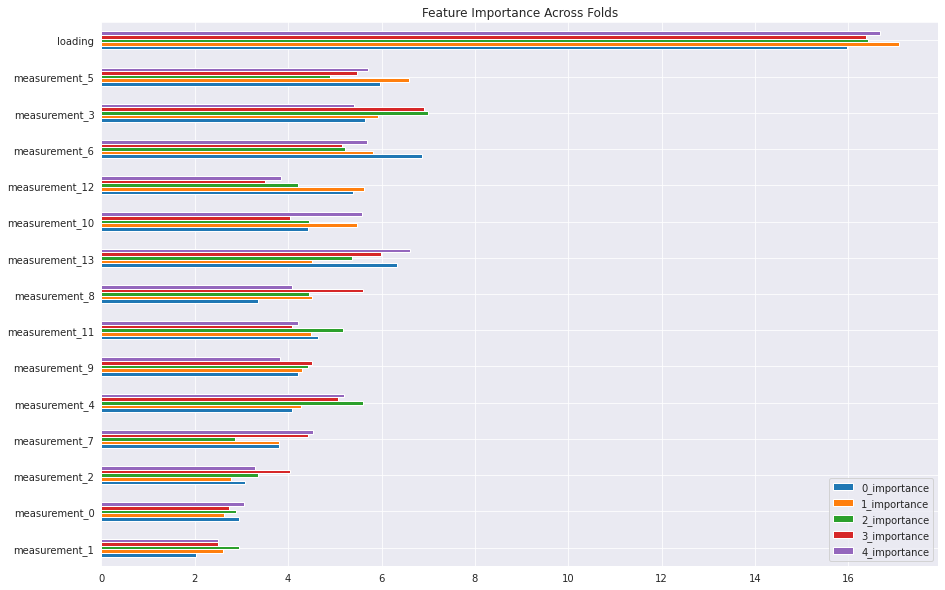

In [29]:
catb_fis_df = pd.concat(catb_fimp, axis = 1).head(15)
catb_fis_df.sort_values('1_importance').plot(kind = 'barh', figsize = (15, 10), title = 'Feature Importance Across Folds')
plt.show()

In [30]:
lgb_params = {
    'objective': 'binary',    
    'metric': 'auc',    
    'device': 'cpu',             
    'num_iterations': 100,        # Same as num_tree, n_iter, n_estimators. Default = 100
    'learning_rate': 0.1,         # Same as eta, default = 0.1
    'num_leaves': 10,             # Default = 31
    'max_depth': 2,               # Default = -1
    'bagging_freq': 0,            # 0 = disable bagging, default = 0
    'feature_fraction': 1,        # Randomly select n% of features on each iteration
    'lambda_l1': 0,               # Default = 0
    'lambda_l2': 0,               # Default = 0
}

In [31]:
lgb_predictions = []
lgb_scores = []
lgb_fimp = []

cv = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = RANDOM_STATE)
for fold, (train_idx, valid_idx) in enumerate(cv.split(train[FEATURES], train[TARGET])):
    
    print(10*"=", f"Fold = {fold + 1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][FEATURES], train.iloc[valid_idx][FEATURES]
    y_train, y_valid = train[TARGET].iloc[train_idx], train[TARGET].iloc[valid_idx]
    
    model = LGBMClassifier(**lgb_params)
    model.fit(X_train, y_train, verbose = 0)
    
    pred_valid = model.predict_proba(X_valid[FEATURES])[:,1]
    acc = roc_auc_score(y_valid, pred_valid)
    lgb_scores.append(acc)
    run_time = time.time() - start_time
    
    print(f"Fold = {fold + 1}, Accuracy: {acc:.2f}, Run Time: {run_time:.2f}s")
    test_pred = model.predict(test[FEATURES])
    fim = pd.DataFrame(index = FEATURES,
                      data = model.feature_importances_,
                      columns = [f'{fold}_importance'])
    lgb_fimp.append(fim)
    lgb_predictions.append(test_pred)
    
print("Mean Accuracy :", np.mean(lgb_scores))

========== Fold = 1 ==========
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
Fold = 1, Accuracy: 0.58, Run Time: 0.22s
========== Fold = 2 ==========
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
Fold = 2, Accuracy: 0.58, Run Time: 0.18s


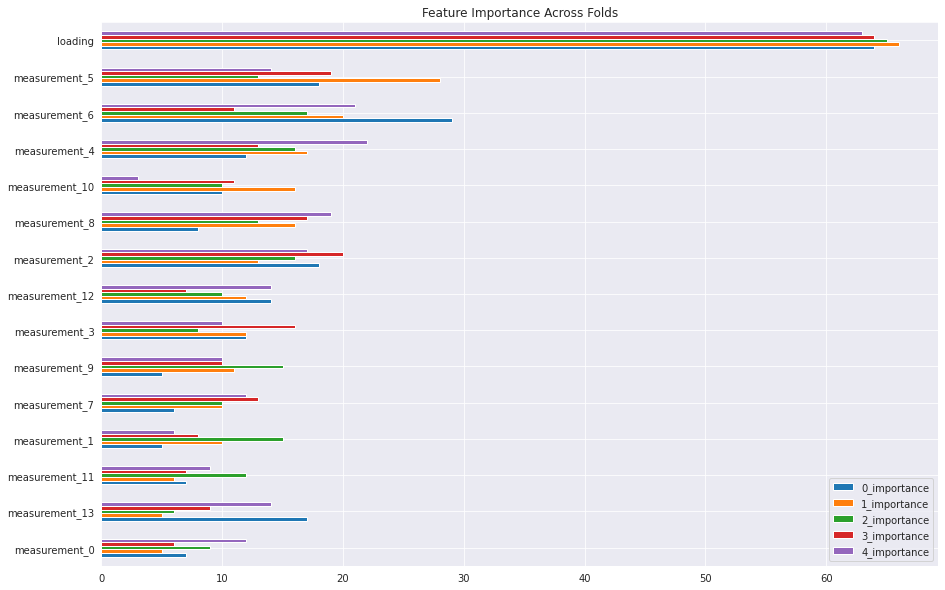

In [32]:
lgbm_fis_df = pd.concat(lgb_fimp, axis = 1).head(15)
lgbm_fis_df.sort_values('1_importance').plot(kind = 'barh', figsize = (15, 10), title = 'Feature Importance Across Folds')
plt.show()

In [33]:
xgb_params = {
    'objective': 'binary:logistic', # For multiclass classification
    'eval_metric': 'auc',         # Default to multiclass classification
    'booster': 'gbtree',          # Default value
    'eta': 0.01,                   # Learning rate, default = 0.3
    'gamma': 0,                   # min_split_loss, default = 0
    'max_depth': 2,               # Maximum depth of a tree, default = 6
    'lambda': 1,                  # L2 regularization term on weights, default = 1
    'alpha': 0,                   # L1 regularization term on weights, default = 0
}

In [34]:
xgb_predictions = []
xgb_scores = []
xgb_fimp = []

cv = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = RANDOM_STATE)
for fold, (train_idx, valid_idx) in enumerate(cv.split(train[FEATURES], train[TARGET])):
    
    print(10*"=", f"Fold = {fold + 1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][FEATURES], train.iloc[valid_idx][FEATURES]
    y_train, y_valid = train[TARGET].iloc[train_idx], train[TARGET].iloc[valid_idx]
    
    model = XGBClassifier(**xgb_params) # Use ** to pass a dictionary for parameters
    model.fit(X_train[FEATURES], y_train, verbose = 0)
    
    pred_valid = model.predict_proba(X_valid[FEATURES])[:,1]
    acc = roc_auc_score(y_valid, pred_valid)
    xgb_scores.append(acc)
    run_time = time.time() - start_time
    
    print(f"Fold = {fold + 1}, Accuracy: {acc:.4f}, Run Time: {run_time:.2f}s")
    test_pred = model.predict_proba(test[FEATURES])
    fim = pd.DataFrame(index = FEATURES,
                      data = model.feature_importances_,
                      columns = [f'{fold}_importance'])
    xgb_fimp.append(fim)
    xgb_predictions.append(test_pred)
    
print("Mean Accuracy :", np.mean(xgb_scores))

========== Fold = 1 ==========
Fold = 1, Accuracy: 0.5846, Run Time: 1.20s
========== Fold = 2 ==========
Fold = 2, Accuracy: 0.5887, Run Time: 1.28s
========== Fold = 3 ==========
Fold = 3, Accuracy: 0.5924, Run Time: 1.18s
========== Fold = 4 ==========
Fold = 4, Accuracy: 0.5905, Run Time: 1.18s
========== Fold = 5 ==========
Fold = 5, Accuracy: 0.5847, Run Time: 1.21s
Mean Accuracy : 0.588153683912561


In [35]:
xgb_predictions_GroupK = []
xgb_scores_GroupK = []
xgb_fimp_GroupK = []

cv = GroupKFold(n_splits = 5)
for fold, (train_idx, valid_idx) in enumerate(cv.split(train[FEATURES], train[TARGET], train['product_code'])):
    
    print(10*"=", f"Fold = {fold + 1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][FEATURES], train.iloc[valid_idx][FEATURES]
    y_train, y_valid = train[TARGET].iloc[train_idx], train[TARGET].iloc[valid_idx]
    
    model = XGBClassifier(**xgb_params) # Use ** to pass a dictionary for parameters
    model.fit(X_train[FEATURES], y_train, verbose = 0)
    
    pred_valid = model.predict_proba(X_valid[FEATURES])[:,1]
    acc = roc_auc_score(y_valid, pred_valid)
    xgb_scores_GroupK.append(acc)
    run_time = time.time() - start_time
    
    print(f"Fold = {fold + 1}, Accuracy: {acc:.4f}, Run Time: {run_time:.2f}s")
    test_pred = model.predict_proba(test[FEATURES])
    fim = pd.DataFrame(index = FEATURES,
                      data = model.feature_importances_,
                      columns = [f'{fold}_importance'])
    xgb_fimp_GroupK.append(fim)
    xgb_predictions_GroupK.append(test_pred)
    
print("Mean Accuracy :", np.mean(xgb_scores_GroupK))

========== Fold = 1 ==========
Fold = 1, Accuracy: 0.5831, Run Time: 1.16s
========== Fold = 2 ==========
Fold = 2, Accuracy: 0.5805, Run Time: 1.19s
========== Fold = 3 ==========
Fold = 3, Accuracy: 0.5846, Run Time: 1.19s
========== Fold = 4 ==========
Fold = 4, Accuracy: 0.5957, Run Time: 1.20s
========== Fold = 5 ==========
Fold = 5, Accuracy: 0.5952, Run Time: 1.20s
Mean Accuracy : 0.5878103579752982


In [36]:
lg_predictions_GroupK = []
lg_score_GroupK = []
lg_fimp_GroupK = []

cv = GroupKFold(n_splits = 5) # must be 5 because of the 5 product codes
for fold, (train_idx, valid_idx) in enumerate(cv.split(train[FEATURES], train[TARGET], train['product_code'])):
    
    print(10*"=", f"Fold = {fold + 1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][FEATURES], train.iloc[valid_idx][FEATURES]
    y_train, y_valid = train[TARGET].iloc[train_idx], train[TARGET].iloc[valid_idx]
    
    model = LogisticRegression(penalty='l1', C=0.01, solver='liblinear', random_state=1)
    model.fit(X_train[FEATURES], y_train)

    y_valid_pred = model.predict_proba(X_valid[FEATURES])[:,1]
    score = roc_auc_score(y_valid, y_valid_pred)
    print(f"Fold {fold}: auc = {score:.5f}")
    lg_score_GroupK.append(score)

    lg_predictions_GroupK.append(model.predict_proba(test[FEATURES])[:,1])

# Show overall score
print("Mean Accuracy :", np.mean(lg_score_GroupK))

========== Fold = 1 ==========
Fold 0: auc = 0.58602
========== Fold = 2 ==========
Fold 1: auc = 0.58075
========== Fold = 3 ==========
Fold 2: auc = 0.58946
========== Fold = 4 ==========
Fold 3: auc = 0.59501
========== Fold = 5 ==========
Fold 4: auc = 0.59551
Mean Accuracy : 0.5893494009005048


In [37]:
lg_predictions = []
lg_score = []
lg_fimp = []

cv = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = RANDOM_STATE)
for fold, (train_idx, valid_idx) in enumerate(cv.split(train[FEATURES], train[TARGET])):
    
    print(10*"=", f"Fold = {fold + 1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][FEATURES], train.iloc[valid_idx][FEATURES]
    y_train, y_valid = train[TARGET].iloc[train_idx], train[TARGET].iloc[valid_idx]
    
    model = LogisticRegression(penalty='l1', C=0.01, solver='liblinear', random_state=1)
    model.fit(X_train[FEATURES], y_train)

    y_valid_pred = model.predict_proba(X_valid[FEATURES])[:,1]
    score = roc_auc_score(y_valid, y_valid_pred)
    print(f"Fold {fold}: auc = {score:.5f}")
    lg_score.append(score)

    lg_predictions.append(model.predict_proba(test[FEATURES])[:,1])

# Show overall score
print("Mean Accuracy :", np.mean(lg_score))

========== Fold = 1 ==========
Fold 0: auc = 0.58758
========== Fold = 2 ==========
Fold 1: auc = 0.58562
========== Fold = 3 ==========
Fold 2: auc = 0.59506
========== Fold = 4 ==========
Fold 3: auc = 0.59186
========== Fold = 5 ==========
Fold 4: auc = 0.58543
Mean Accuracy : 0.5891091671507808


In [38]:
pd.DataFrame({'Model': ['CatBoost', 'LightGBM','XGBoost (GroupKFold)', 'XGBoost', 'Logistic Regression (GroupKFold)', 'Logistic Regression'], 
              'Average AUC': [np.mean(catb_scores), np.mean(lgb_scores), np.mean(xgb_scores_GroupK), np.mean(xgb_scores), np.mean(lg_score_GroupK), np.mean(lg_score)]})

,Model,Average AUC
0,CatBoost,0.574956
1,LightGBM,0.584039
2,XGBoost (GroupKFold),0.587810
3,XGBoost,0.588154
4,Logistic Regression (GroupKFold),0.589349
5,Logistic Regression,0.589109


In [39]:
lg_groupK_submission = submission.copy()
lg_groupK_submission['failure'] = sum(lg_predictions_GroupK)/len(lg_predictions_GroupK)
lg_groupK_submission.to_csv('Logistic_GroupK.csv', index=False)
lg_groupK_submission.head()

,id,failure
0,26570,0.206031
1,26571,0.187285
2,26572,0.196229
3,26573,0.195336
4,26574,0.318883


In [40]:
lg_submission = submission.copy()
lg_submission['failure'] = sum(lg_predictions)/len(lg_predictions)
lg_submission.to_csv('Logistic.csv', index=False)
lg_submission.head()

,id,failure
0,26570,0.205757
1,26571,0.187419
2,26572,0.195954
3,26573,0.195230
4,26574,0.319735
